can I get it to work with dali + custom fastai dataloaders etc

In [3]:

from tqdm import tqdm
import numpy as np
import cv2
from functools import partial

from pytorch_toolbelt import losses as L
from torchvision.transforms import *
from fastai.imports import *
from fastai.vision import *
from fastai.metrics import *
from fastai.callbacks import *
from nvidia.dali.plugin.pytorch import DALIGenericIterator as PyTorchIterator
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types


import collections
from random import shuffle

from torch import Tensor

# from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    "Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"
from importlib import reload

In [38]:
imagenette_means = Tensor([0.4879, 0.4740, 0.4307])
imagenette_std_devs = Tensor([0.2814, 0.2831, 0.3079])

In [4]:
def bbox2(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax


In [79]:
def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    '''
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

In [183]:
data_dir = Path("/media/wwymak/Storage/kaggle-satellite-clouds")
train_dir = data_dir / "train"

train_meta = pd.read_csv(data_dir / "train.csv.zip")
class_mapping = OrderedDict({"Fish": 1, "Flower":2, "Gravel":3, "Sugar":4})
train_meta['filename'] = train_meta.Image_Label.apply(lambda x: x.split('_')[0])
train_meta['class_label'] = train_meta.Image_Label.apply(lambda x: x.split('_')[1])
train_meta['cls'] = train_meta.class_label.apply(lambda x: class_mapping[x])

filenames_shuffled = train_meta['filename'].sample(frac=1., random_state=42).reset_index(drop=True)

train_meta = train_meta.sample(frac=1., random_state=42).reset_index(drop=True)
train_meta['is_train_set']=True
train_meta.loc[train_meta.filename.isin(filenames_shuffled[int(0.8 * len(train_meta)):]), 'is_train_set'] = False

In [184]:
(train_meta.is_train_set == False).sum()

12952

In [185]:
class ExternalInputIterator(object):
    def __init__(self, batch_size, images_dir, data_df, shape=(1400,2100), is_train_set=True):
        self.images_dir = images_dir
        if is_train_set:
             self.data_df = data_df[data_df["is_train_set"] == True]
        else:
            self.data_df = data_df[data_df["is_train_set"] == False]
        self.batch_size = batch_size
        self.files = [self.images_dir / x for x in  self.data_df['filename'].unique()]
#         print(len(self.files), set([x.suffix for x in self.files]))
        # whole data set size
        self.data_set_len = len(self.data_df)
        self.n = len(self.files)
        self.shape = shape

    def __iter__(self):
        self.i = 0
        shuffle(self.files)
        return self

    def __next__(self):
        batch = []
        labels = []
        files = []

        if self.i >= self.n:
            raise StopIteration

        for _ in range(self.batch_size):
            jpeg_filename= self.files[self.i]
            mask = self._make_mask(Path(jpeg_filename).name, shape=self.shape)
            f = open(jpeg_filename, 'rb')
            
            batch.append(np.frombuffer(f.read(), dtype = np.uint8))
            labels.append(mask)
            files.append(jpeg_filename)
            self.i = (self.i + 1) % self.n

        return (batch, labels, files)
    
    def _make_mask(self, image_name: str='img.jpg', shape: tuple = (1400, 2100)):
        """
        Create mask based on df, image name and shape.
        """
        df_subset = self.data_df[self.data_df['filename'] == image_name]
        print(df_subset.shape)
#         print(df_subset, image_name, self.data_df['filename'][0])
        encoded_masks = df_subset['EncodedPixels']
        classes = df_subset.cls

        masks = np.zeros(( shape[0], shape[1],4), dtype=np.uint8)

        for cls, label in list(zip(classes, encoded_masks)):
            if label is not np.nan:

                mask = rle_decode(label, shape=shape)
                masks[:,:,cls-1] = mask
#         masks = torch.from_numpy(masks)
#         masks.to('cuda')
        return masks

    @property
    def size(self,):
        return self.data_set_len
    next = __next__

In [186]:
class ExternalSourcePipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, external_data, image_size, is_train_set=True):
        super().__init__(batch_size,
                                      num_threads,
                                      device_id)
        self.input = ops.ExternalSource()
        self.input_mask = ops.ExternalSource()
        self.image_size = image_size
        self.is_train_set = is_train_set
        self.decode = ops.ImageDecoder(device = "mixed", output_type = types.RGB)
        
        self.resize = ops.Resize(device="gpu", resize_x=image_size, resize_y=image_size)
#         self.resize = ops.Resize(device="gpu", resize_shorter=image_size)
        self.cast = ops.Cast(device = "gpu",
                             dtype = types.UINT8)
        
        # Will flip vertically with prob of 0.1
        
        self.flip_coin = ops.CoinFlip(probability=0.5)
        self.rotate_range = ops.Uniform(range = (-70, 70))
        self.rotate_coin = ops.CoinFlip(probability=0.3)
        
        self.contrast_range = ops.Uniform(range=(0.8, 1.3))
        self.hue_range = ops.Uniform(range=(0.8, 1.3))
        
        # augmentataions
        self.augmentations = {}
        self.augmentations["vert_flip"] = ops.Flip(device='gpu', horizontal=0)
        self.augmentations["horizontal_flip"] = ops.Flip(device='gpu', vertical=0)
        self.augmentations["contrast"] = ops.Contrast(device = "gpu")
        self.augmentations["brightness"] = ops.Brightness(device = "gpu")
        self.augmentations["saturation"] = ops.Saturation(device = "gpu")
        self.augmentations["hue"] = ops.Hue(device = "gpu")
        self.augmentations["rotate"] = ops.Rotate(device = "gpu",  interp_type = types.INTERP_NN)
        imagenette_means = Tensor([0.4879, 0.4740, 0.4307])
        imagenette_std_devs = Tensor([0.2814, 0.2831, 0.3079])
        
        self.cmnp = ops.CropMirrorNormalize(device='gpu',
                                            output_dtype=types.FLOAT,
                                            output_layout=types.NCHW,
                                            image_type=types.RGB,
                                            mean=listify(imagenette_means*255),
                                            std=listify(imagenette_std_devs*255))
        self.transpose = ops.Transpose(perm=[2,0,1], device="gpu")
        
        
        self.external_data = external_data
        self.iterator = iter(self.external_data)
        

    def define_graph(self):
        prob_vert_flip = self.flip_coin()
        prob_horizontal_flip = self.flip_coin()
        prob_mirror = self.flip_coin()
        
        prob_rotate = self.rotate_coin()
        rotate_range = self.rotate_range()
        
        
        self.jpegs = self.input()
        self.masks = self.input_mask()
    

        masks = self.masks.gpu()
        masks = self.resize(masks)
        
        images = self.decode(self.jpegs)
        images = self.resize(images)
        
        if self.is_train_set:
            images = self.augmentations["contrast"](images, contrast=self.contrast_range())
            images = self.augmentations["brightness"](images, brightness=self.contrast_range())
            images = self.augmentations["saturation"](images, saturation=self.contrast_range())

            images = self.augmentations["rotate"](images, angle=rotate_range, mask=prob_rotate)
            masks = self.augmentations["rotate"](masks, angle=rotate_range, mask=prob_rotate)
            
        masks = self.transpose(masks)
        images = self.cmnp(images)        
        

        
        return (images, masks)

    def iter_setup(self):
        try:
            (images, masks, files) = self.iterator.next()
            print('here', files)

            self.feed_input(self.jpegs, images)
            self.feed_input(self.masks, masks)

        except StopIteration:
            self.iterator = iter(self.external_data)
            print('stop uiteration error')
            raise StopIteration


In [187]:
# batch_size = 8
# image_size=256
# epochs=2
# eii = ExternalInputIterator( batch_size=batch_size, images_dir=train_dir, data_df=train_meta)
# pipe = ExternalSourcePipeline(batch_size=batch_size, num_threads=8, device_id = 0,
#                               external_data = eii,image_size=image_size)
# pii = PyTorchIterator(pipe,['data', 'label'], size=eii.size, last_batch_padded=True, fill_last_batch=False)
# counter = 0
# for e in range(epochs):
#     for i, data in enumerate(pii):
#         print(f"epoch: {e}, iter {i}, real batch size: {len(data[0]['data'])}")
#         print(len(data), data[0]["data"][0].shape,  data[0]["label"][0].shape, data[0]["label"].shape)
#         counter +=1
#         if counter > 10:
#               break
#     pii.reset()
# counter = 0
# for e in range(epochs):
#     for i, data in enumerate(pii):
#         print(f"epoch: {e}, iter {i}, real batch size: {len(data[0]['data'])}")
#         print(len(data), data[0]["data"][0].shape,  data[0]["label"][0].shape, data[0]["label"].shape)
#         counter +=1
#         if counter > 10:
#               break
#     pii.reset()



In [188]:


batch_size = 8
image_size=256
epochs=2
eii = ExternalInputIterator( batch_size=batch_size, images_dir=train_dir, data_df=train_meta, is_train_set=False)
pipe = ExternalSourcePipeline(batch_size=batch_size, num_threads=8, device_id = 0,
                              external_data = eii,image_size=image_size, is_train_set=False)
train_dali_dl = PyTorchIterator(pipe,['data', 'label'], size=eii.size, last_batch_padded=True, fill_last_batch=False)




def denorm_batch(normed_batch):
    means = imagenette_means.view(1,3,1,1).cuda()
    std_devs = imagenette_std_devs.view(1,3,1,1).cuda()
    return torch.clamp((normed_batch * std_devs + means), min=0)



(4, 6)
(4, 6)
(4, 6)
(4, 6)
(4, 6)
(4, 6)
(4, 6)
(4, 6)
here [PosixPath('/media/wwymak/Storage/kaggle-satellite-clouds/train/dc37348.jpg'), PosixPath('/media/wwymak/Storage/kaggle-satellite-clouds/train/197b5b7.jpg'), PosixPath('/media/wwymak/Storage/kaggle-satellite-clouds/train/b546d12.jpg'), PosixPath('/media/wwymak/Storage/kaggle-satellite-clouds/train/fbb6ac6.jpg'), PosixPath('/media/wwymak/Storage/kaggle-satellite-clouds/train/3af5485.jpg'), PosixPath('/media/wwymak/Storage/kaggle-satellite-clouds/train/f0f5faf.jpg'), PosixPath('/media/wwymak/Storage/kaggle-satellite-clouds/train/2d6d2f2.jpg'), PosixPath('/media/wwymak/Storage/kaggle-satellite-clouds/train/50de31c.jpg')]
(4, 6)
(4, 6)
(4, 6)
(4, 6)
(4, 6)
(4, 6)
(4, 6)
(4, 6)
here [PosixPath('/media/wwymak/Storage/kaggle-satellite-clouds/train/f50c84e.jpg'), PosixPath('/media/wwymak/Storage/kaggle-satellite-clouds/train/e8026e4.jpg'), PosixPath('/media/wwymak/Storage/kaggle-satellite-clouds/train/f847a0a.jpg'), PosixPath('/media/

In [189]:
next_batch = next(train_dali_dl)[0]

len(next_batch['label'])
# def show_xys(self, xs, ys, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
#     "Show the `xs` (inputs) and `ys` (targets) on a figure of `figsize`."
#     rows = int(np.ceil(math.sqrt(len(xs))))
#     axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize)
#     for x,y,ax in zip(xs, ys, axs.flatten()): x.show(ax=ax, y=y, **kwargs)
#     for ax in axs.flatten()[len(xs):]: ax.axis('off')
#     plt.tight_layout()

8

In [190]:


def visualize(image, mask):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}
    
    f, ax = plt.subplots(1, 5, figsize=(24, 24))
    image = ToPILImage()(image.cpu())
    mask = mask.cpu().numpy()

    ax[0].imshow(image)
    for i in range(4):
        ax[i + 1].imshow(mask[i,:, :])
        ax[i + 1].set_title(f'Mask {class_dict[i]}', fontsize=fontsize)
    

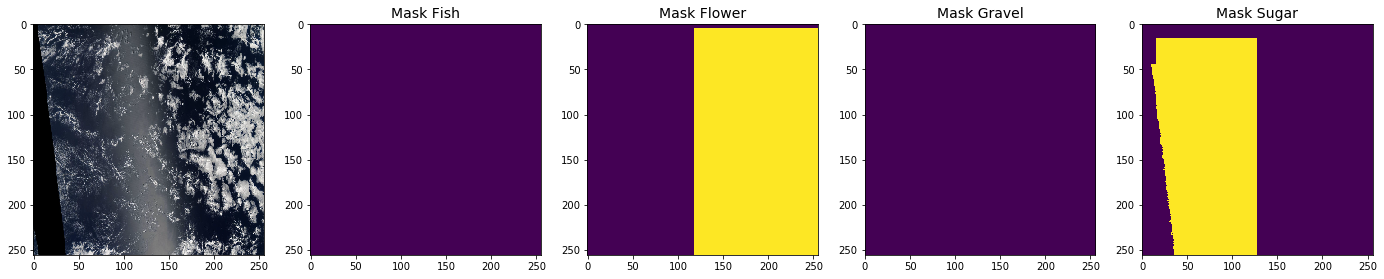

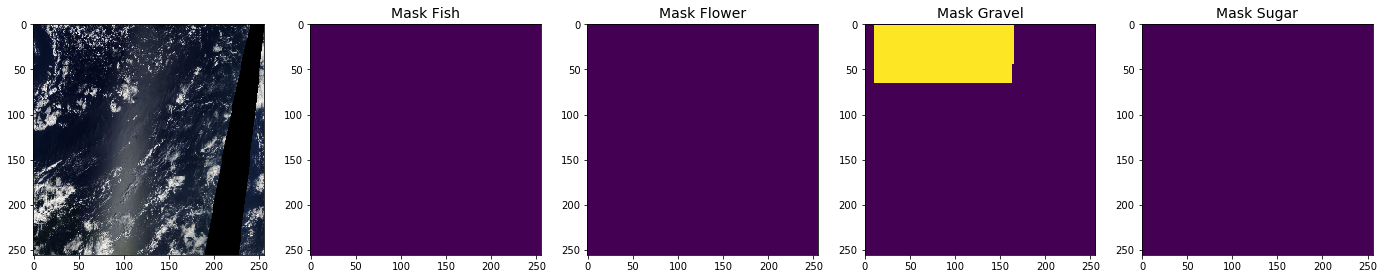

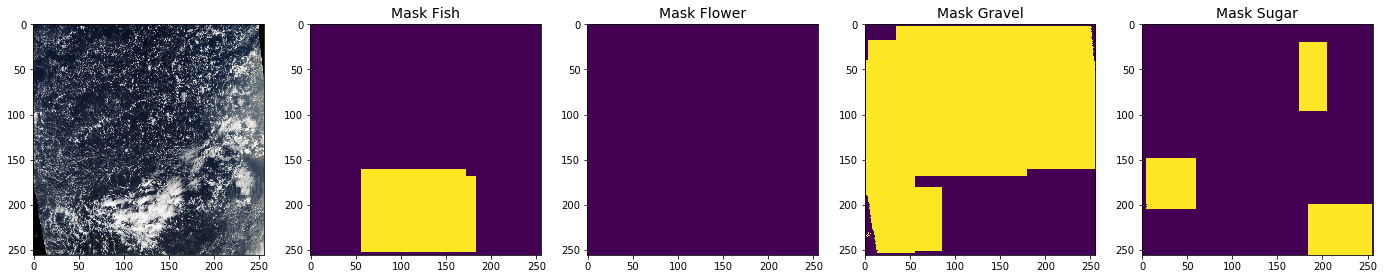

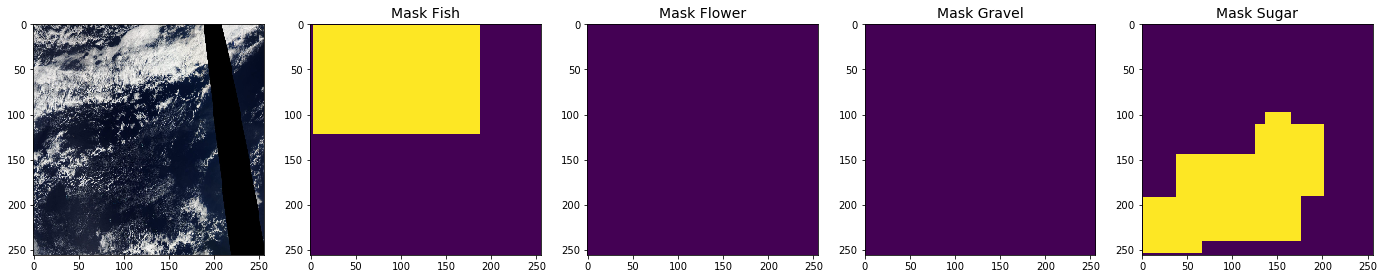

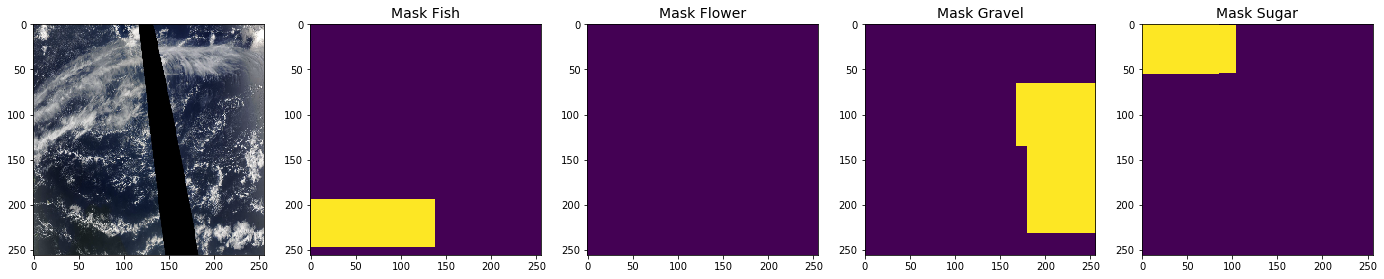

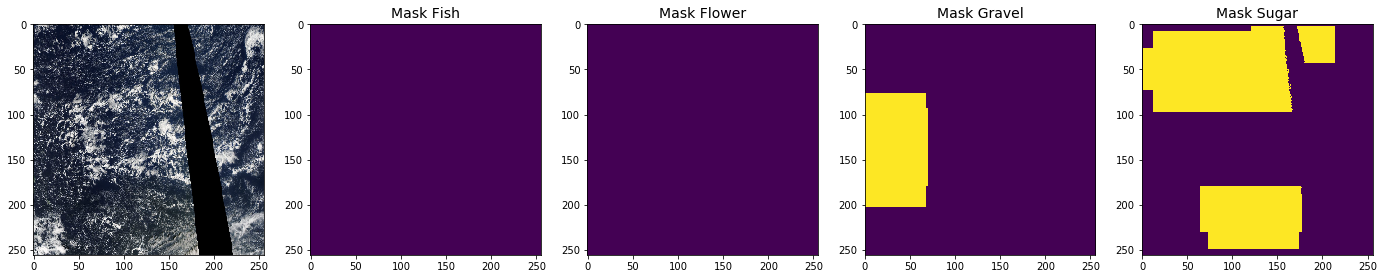

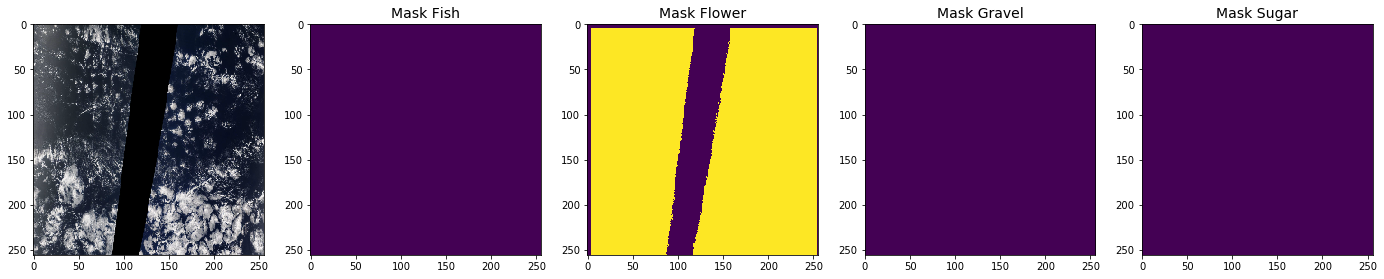

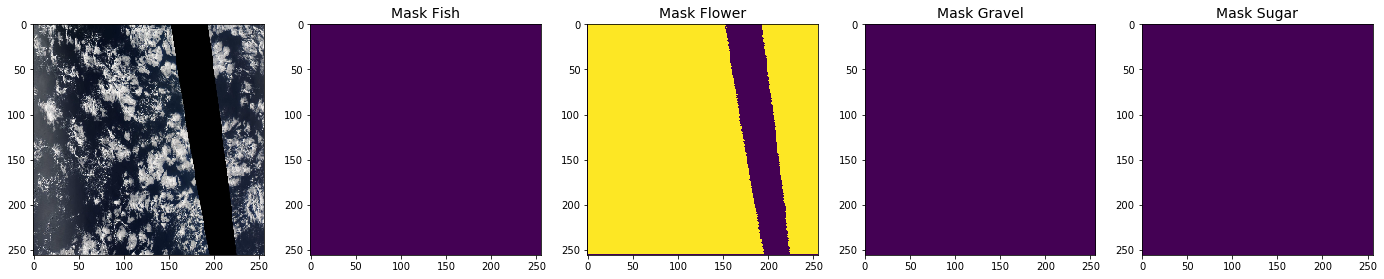

In [191]:
image_batch = denorm_batch(next_batch['data'])
mask_batch = next_batch['label']

for img, mask in zip(image_batch, mask_batch):
    visualize(img, mask)

In [192]:
def visualize_normal(image_fname, mask):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}
    
    f, ax = plt.subplots(1, 5, figsize=(24, 24))
    image = np.array(PIL.Image.open(train_dir/image_fname))


    ax[0].imshow(image)
    for i in range(4):
        ax[i + 1].imshow(mask[i,:, :])
        ax[i + 1].set_title(f'Mask {class_dict[i]}', fontsize=fontsize)
    

paths = [
   Path('/media/wwymak/Storage/kaggle-satellite-clouds/train/dc37348.jpg'), Path('/media/wwymak/Storage/kaggle-satellite-clouds/train/197b5b7.jpg'), Path('/media/wwymak/Storage/kaggle-satellite-clouds/train/b546d12.jpg'), Path('/media/wwymak/Storage/kaggle-satellite-clouds/train/fbb6ac6.jpg'), Path('/media/wwymak/Storage/kaggle-satellite-clouds/train/3af5485.jpg'), Path('/media/wwymak/Storage/kaggle-satellite-clouds/train/f0f5faf.jpg'), Path('/media/wwymak/Storage/kaggle-satellite-clouds/train/2d6d2f2.jpg'), Path('/media/wwymak/Storage/kaggle-satellite-clouds/train/50de31c.jpg') 
]
fnames = [x.name for x in paths]

masks_normal = [make_mask(train_meta, fname) for fname in fnames]

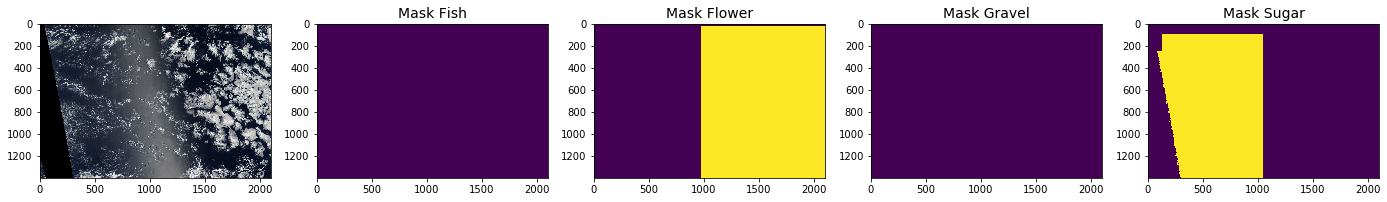

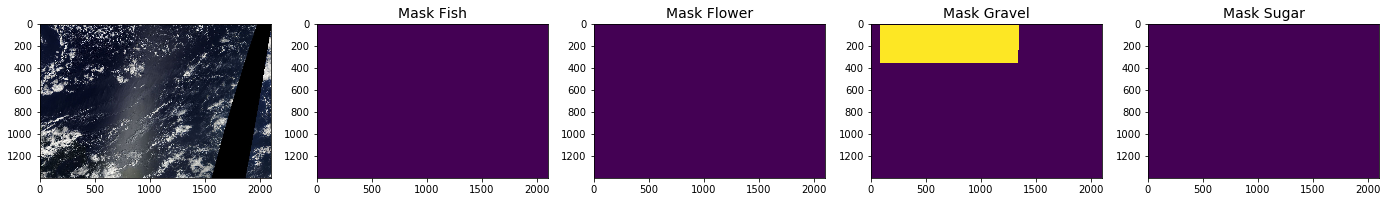

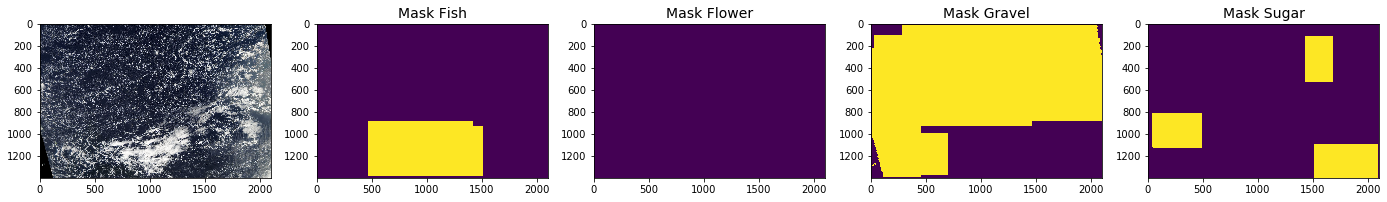

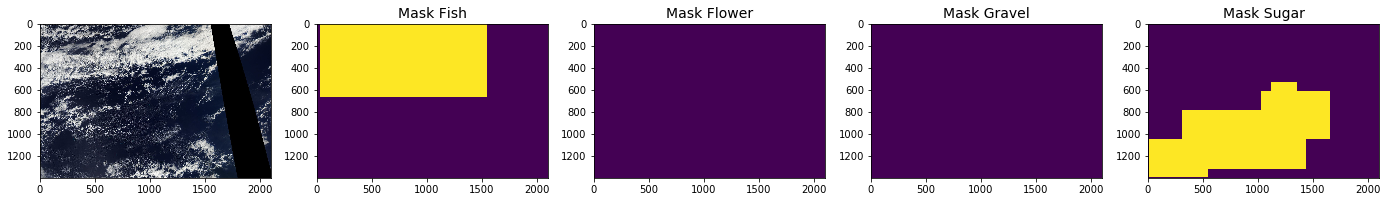

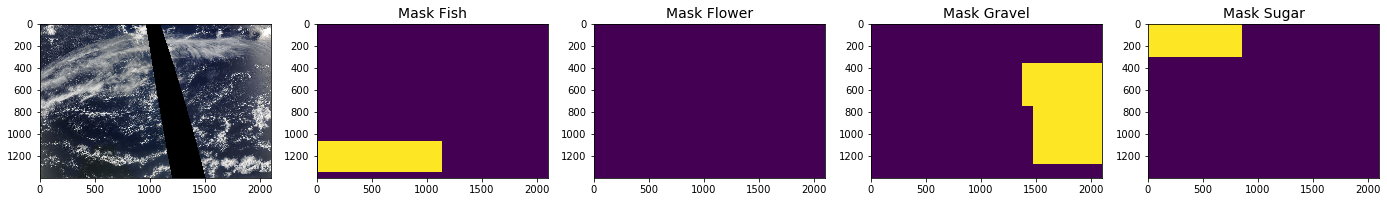

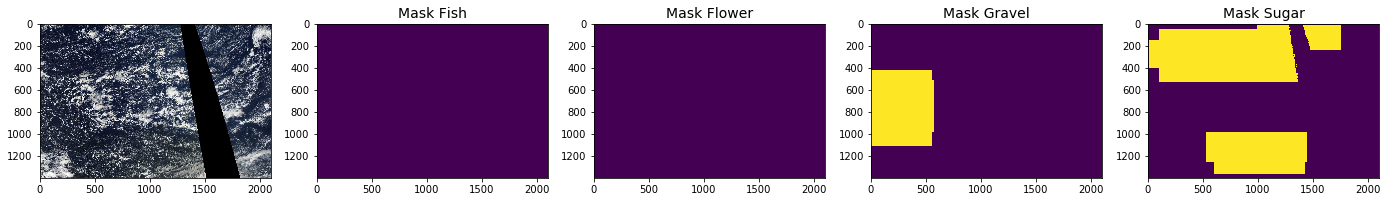

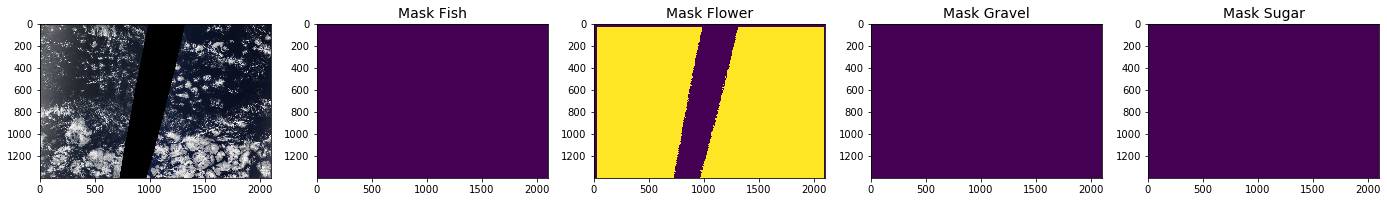

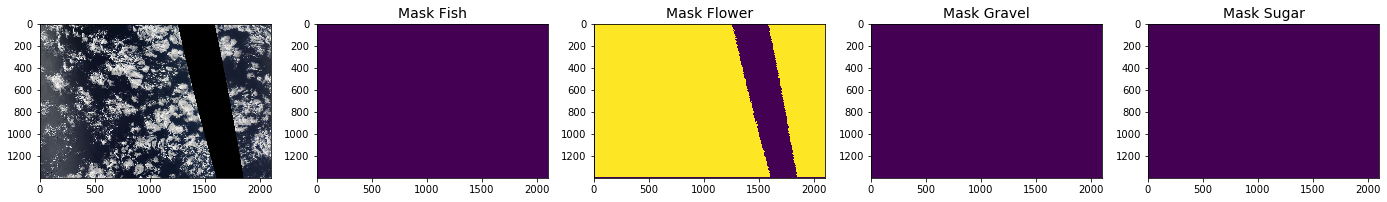

In [193]:

for img, mask in zip(paths, masks_normal):
    visualize_normal(img, mask)

In [19]:
class TrainPipeline(Pipeline):
    def __init__(self, batch_size=bs, num_threads=8, device_id=0, image_size=256):
        super().__init__(batch_size, num_threads, device_id)
        self.image_size = image_size
        self.input = ops.FileReader(file_root = train_dir, random_shuffle=True)
        
        # Randomly crop and resize
        self.decode = ops.ImageDecoderRandomCrop(device='mixed', output_type=types.RGB,
                                                  random_area=[0.08,1.0], 
                                                  random_aspect_ratio=[0.75,1.333333], 
                                                  num_attempts=100)
        self.augmentations = {}
        self.augmentations["jitter"] = ops.Jitter(device = "gpu")
        self.augmentations["water"] = ops.Water(device = "gpu")
        self.augmentations["shpere"] = ops.Sphere(device = "gpu")
        self.augmentations["rotate"] = ops.Rotate(device = "gpu",  interp_type = types.INTERP_NN)
        self.augmentations["warpaffine"] = ops.WarpAffine(device = "gpu", matrix = [1.0, 0.8, 0.0, 0.0, 1.2, 0.0],
                                                 use_image_center = True, interp_type = types.INTERP_LINEAR)
        self.augmentations["contrast"] = ops.Contrast(device = "gpu")
        self.augmentations["brightness"] = ops.Brightness(device = "gpu")
        self.augmentations["saturation"] = ops.Saturation(device = "gpu")
        self.augmentations["hue"] = ops.Hue(device = "gpu", hue = 45.)
        
        self.augmentations["resize"] = ops.Resize(device = "gpu", 
                                                  resize_x=self.image_size, resize_y=self.image_size,
                                 interp_type=types.INTERP_NN)
        self.augmentations["vertical_flip"] = ops.Flip(device = "gpu", horizontal = 0, interp_type=types.INTERP_NN)
        self.augmentations["horizontal_flip"] = ops.Flip(device = "gpu", vertical = 0, interp_type=types.INTERP_NN)
        self.uniform = ops.Uniform(range = (0.0, 1.0))
        self.coin = op.CoinFlip()
        self.iter = 0
        
       
        
        # Will flip vertically with prob of 0.1
        self.vert_flip = ops.Flip(device='gpu', horizontal=0, interp_type=types.INTERP_NN)
        self.flip_coin = ops.CoinFlip(probability=0.5)
        
         # Will flip horizontally with prob of 0.5
        self.vert_flip = ops.Flip(device='gpu', vertical=0, interp_type=types.INTERP_NN)
        self.vert_coin = ops.CoinFlip(probability=0.5)
        
        # My workaround for Dali not supporting random affine transforms: 
        # a "synthetic random" warp affine transform.
        self.num_warp_tfms = 7
        self.affine_tfms = [get_affine_tfm(self.image_size, 0.1) for i in range(self.num_warp_tfms)]
        self.warp_tfms = [ops.WarpAffine(device='gpu', matrix=i, interp_type=types.INTERP_NN) for i in self.affine_tfms]
        self.warp_prob = ops.CoinFlip(probability=0.025)
        
        # Rotate within a narrow range with probability of 0.075

        self.rotate_range = ops.Uniform(range = (-50,50))
        self.rotate_coin = ops.CoinFlip(probability=0.5)
        
        # Flip horizontally with prob of 0.5, then convert tensor format from 
        # NHWC to NCHW and normalize.
        self.cmnp = ops.CropMirrorNormalize(device='gpu',
                                            output_dtype=types.FLOAT,
                                            output_layout=types.NCHW,
                                            crop=(im_size, im_size),
                                            image_type=types.RGB,
                                            mean=listify(imagenet_stats[0]*255),
                                            std=listify(imagenet_stats[1]*255))
        self.mirror_coin  = ops.CoinFlip(probability=0.5)
        
    def define_graph(self):
        # Generate new random numbers for each mini-batch
        prob_vert_flip = self.flip_coin()
        prob_horizontal_flip = self.flip_coin()
        prob_rotate = self.rotate_coin()
        prob_mirror = self.mirror_coin()
        angle_range = self.rotate_range()
        warp_probs = [self.warp_prob() for i in range(self.num_warp_tfms)]

        # Perform pipeline operations in the order they appear below:
        self.jpegs, self.labels = self.input()
        images = self.decode(self.jpegs)
        images = self.resize(images)
        images = self.augmentations["vertical_flip"](images, vertical=prob_vert_flip)
        images = self.augmentations["horizontal"](images, horizontal=prob_horizontal_flip)
        
        for i, tfm in enumerate(self.warp_tfms):
            images = tfm(images, mask=self.warp_probs[i])
        images = self.augmentation["rotate"](images, angle=angle_range, mask=prob_rotate)

        images = self.cmnp(images, mirror=prob_mirror)        
        return (images, self.labels)

NameError: name 'bs' is not defined

In [167]:
def make_mask(df: pd.DataFrame, image_name: str='img.jpg', shape: tuple = (1400, 2100)):
    """
    Create mask based on df, image name and shape.
    """
    df_subset = df.loc[df['filename'] == image_name]
    encoded_masks = df_subset['EncodedPixels']
    classes = df_subset.cls
    
    masks = np.zeros((4, shape[0], shape[1]), dtype=np.float32)

    for cls, label in list(zip(classes, encoded_masks)):
        if label is not np.nan:
            mask = rle_decode(label, shape=shape)
            masks[cls-1, :,: ] = mask
            
    return masks

def _make_mask(self, image_name: str='img.jpg', shape: tuple = (1400, 2100)):
        """
        Create mask based on df, image name and shape.
        """
        df_subset = self.data_df[self.data_df['filename'] == image_name]
#         print(df_subset, image_name, self.data_df['filename'][0])
        encoded_masks = df_subset['EncodedPixels']
        classes = df_subset.cls

        masks = np.zeros(( shape[0], shape[1],4), dtype=np.uint8)

        for cls, label in list(zip(classes, encoded_masks)):
            if label is not np.nan:

                mask = rle_decode(label, shape=shape)
                masks[:,:,cls-1] = mask
#         masks = torch.from_numpy(masks)
#         masks.to('cuda')
        return mask

In [17]:
mask4d = make_mask(train_meta, '0011165.jpg')

In [8]:
Pipeline.feed_input??

In [ ]:
class SegmentationLabelList2(SegmentationLabelList):
     def open(self, fn):
         mask_paths = glob.glob(fn + "/*")
         mask_stack = open_mask(mask_paths[0], div=True).data 
         mask_paths = mask_paths[1:]
         for mask_path in mask_paths:
             mask_tensor = open_mask(mask_path, div=True).data
             mask_stack = torch.cat((mask_stack, mask_tensor), dim=0)
         return ImageSegment(mask_stack)


In [ ]:
class SegmentationLabelListMultiChannel(ImageList):
    "`ItemList` for segmentation masks."
    _processor=SegmentationProcessor
    def __init__(self, items:Iterator, classes:Collection=None, **kwargs):
        super().__init__(items, **kwargs)
        self.copy_new.append('classes')
        self.classes,self.loss_func = classes,CrossEntropyFlat(axis=1)

    def open(self, fn): return open_mask(fn)
    def analyze_pred(self, pred, thresh:float=0.5): return pred.argmax(dim=0)[None]
    def reconstruct(self, t:Tensor): return t

class SegmentationItemListMultiChannel(ImageList):
    "`ItemList` suitable for segmentation tasks."
    _label_cls,_square_show_res = SegmentationLabelList,False

In [ ]:
class SatelliteDataset(Dataset):

    def __init__(self, df, img_ids, image_dir, ds_type="train",  shape=(1400,2100),transforms=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.img_ids = img_ids
        self.shape = shape
        self.transforms = transforms
        self.image_dir = image_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.img_ids[idx]
        mask = make_mask(self.df, img_name, self.shape)
        
        image = ToTensor(PIL.Image.open(self.image_dir/img_name))
        
        if self.transform:
            sample = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [26]:
imagenet_stats[0]*255

[0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
 0.406,
 0.485,
 0.456,
